# Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from matplotlib.ticker import FuncFormatter, PercentFormatter

plt.style.use('ggplot')

TITLE_SIZE = 22
TITLE_PADDING = 10

import seaborn as sns

params = {
    'text.color': (0.25, 0.25, 0.25),
    'figure.figsize': [12, 5],
   }
plt.rcParams.update(params)

import pandas as pd
pd.options.display.max_rows = 500

import numpy as np
from numpy import percentile
np.random.seed(42)

import copy
import os
import time
from tabulate import tabulate
from tqdm.notebook import tqdm

from itertools import combinations

In [2]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.preprocessing import FunctionTransformer, LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer, MissingIndicator

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF

from sklearn.metrics import confusion_matrix, classification_report, f1_score, plot_confusion_matrix
from sklearn.inspection import permutation_importance

from sklearn import set_config
from sklearn.compose import make_column_transformer
set_config(display='diagram')

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, BorderlineSMOTE, KMeansSMOTE, SVMSMOTE, SMOTENC
from imblearn.pipeline import make_pipeline as make_imb_pipeline

from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

import lightgbm as lgb

from category_encoders import *
from category_encoders.wrapper import PolynomialWrapper

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

import featuretools as ft

# 1) Data preprocessing
---

We load the data again and perform the necessary preprocessing steps.

In [3]:
train = pd.read_csv("_data/train.csv")
test_kaggle = pd.read_csv("_data/test.csv")
df = pd.concat([train, test_kaggle]).reset_index(drop=True)
print("Check data frame shapes before and after:")
print(train.shape, test_kaggle.shape, df.shape)

# drop redundant features
derivative_features = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
                       'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 
                       'SQBmeaned', 'agesq', "female", "area2"]
df.drop(derivative_features, axis=1, inplace=True)

# «Id» doesn't carry information therefore we can drop this column.
# However, if we want to submit to Kaggle we need to keep this variable.
# df.drop("Id", axis=1, inplace=True)

# Replace 0 for value «no». We do not introduce data leakage since we don't impute anything.
# Replace NaN for value «yes» so we can use an Imputer in the pipeline to properly impute e.g. a mean value while crossvalidating.
cols = ["dependency", "edjefe", "edjefa"]
for col in cols:
    df[col].replace({"no":0}, inplace=True)
    df[col].replace({"yes":np.nan}, inplace=True)
    df[col] = df[col].astype(float)
    
# Clean the one erroneous value for rez_esc. We impute the value based on train data only to avoid data leakage.
years_behind_mean = np.mean(train.rez_esc)
df.loc[df[df.rez_esc==99.0].index, "rez_esc"] = years_behind_mean

# Clean target variable for households that have been qualified with more than one unique class of welfare neediness.
# We set the target class for all members to the one the head of household has.
tmp = df.groupby("idhogar").Target.nunique()
erroneous_households = tmp[tmp>1].index.to_list()
for household in erroneous_households:
    to_fix = df[df.idhogar==household].index
    true_class_label = df[(df.idhogar==household) & (df.parentesco1==1)].Target.values[0]
    df.loc[to_fix, "Target"] = true_class_label

# Remove households without a head of household.
# We only drop samples in the training set because we need all test samples for a Kaggle submission.
tmp = df[df.Target.notnull()].groupby("idhogar").parentesco1.sum()
without_head = tmp[tmp==0].index
to_drop = df[df.idhogar.isin(without_head)].index
df.drop(to_drop, inplace=True)    

# Split again into train and test set.
train = df[df.Target.notnull()].copy()
test_kaggle = df[df.Target.isnull()].copy()

train.reset_index(drop=True, inplace=True)
test_kaggle.reset_index(drop=True, inplace=True)

print(train.shape, test_kaggle.shape, df.shape)

Check data frame shapes before and after:
(9557, 143) (23856, 142) (33413, 143)
(9534, 132) (23856, 132) (33390, 132)


In [4]:
# Read manually annotated codebook and retrieve names for categorical / numerical / individual and household features.
cb = pd.read_excel("_data/codebook_cleaned.xlsx")
to_drop = cb[cb.name.isin(["female", "area2", "idhogar", "Target"])].index
cb.drop(to_drop, inplace=True)
categoricals = cb[cb.cat==1].name.copy()
numericals = cb[cb.cat!=1].name.copy()

indiv_feats = cb[cb.indiv==1].name
house_feats = cb[cb.indiv!=1].name

We need to split a train and test set from the Kaggle training data in order to work locally without relying on Kaggle submissions.

- **The challenge here is to avoid households that are in both data sets – this would introduce a data leakage.** 
- We also want to keep a comparable target class distribution in both splits.

In [5]:
def weighted_split_train_test(train, household_heads_only=False, random_state=42):
    # Calculate class weights and map to target values
    mapping = dict(train.Target.value_counts(normalize=True))
    weights = train.Target.map(mapping)

    household_sample = []
    # Sample a weighted fraction per class thus stratifying the train/test set in regard to target. 
    for class_label in range(1, 5):
        tmp = train[train.Target==class_label]
        tmp = pd.Series(tmp.idhogar.unique()).sample(frac=0.2, weights=weights, random_state=random_state)
        household_sample.extend(tmp)
    
    # Since only heads of households count we can by option reduce the training data only to these samples.
    if household_heads_only==True: 
        train = train[train.parentesco1==1].copy()
        
    # Split data into train and test set.    
    X_train = train[~train.idhogar.isin(household_sample)].drop("Target", axis=1)
    y_train = train[~train.idhogar.isin(household_sample)].Target

    X_test = train[train.idhogar.isin(household_sample)].drop("Target", axis=1)
    y_test = train[train.idhogar.isin(household_sample)].Target

    
#     # Sanity check 1: Do train and test still have a comparable target distribution? Yes, they have.
#     display(train[~train.idhogar.isin(household_sample)].Target.value_counts(normalize=True))
#     print()
#     display(train[train.idhogar.isin(household_sample)].Target.value_counts(normalize=True))
#     print()

#     # Sanity check 2: Do we have same households in both data sets? No, we don't.
#     intersecting_households = len(set.intersection(set(X_train.idhogar), set(X_test.idhogar)))
#     print(f"There are {intersecting_households} households in both train and test data.\n")


    # Extract household ids for GroupKFold
    X_train_groups = X_train.idhogar.values

    X_train.drop("idhogar", axis=1, inplace=True)
    X_test.drop("idhogar", axis=1, inplace=True)

    X_train.reset_index(drop=True, inplace=True)
    X_test.reset_index(drop=True, inplace=True)
       
    return X_train, y_train, X_test, y_test, X_train_groups

In [6]:
# X, y will be the full Kaggle training data set split into predicting features and dependent variable.
X = train.drop(["Id", "idhogar", "Target"], axis=1).copy()
y = train.Target

# X_train etc. are the splits we need for training and evaluating models locally.
# X_train_groups are the household ids. 
# We need those ids for the GroupKFold to avoid same households in train/test split while crossvalidating.
X_train, y_train, X_test, y_test, X_train_groups = weighted_split_train_test(train, household_heads_only=False)

# 2) Baseline models
---

## Dummy classifier
In a first step we build a simple pipeline and set a baseline with a Dummy Classifier.
- A scoring of 0.25 for F1 macro makes intuitive sense: We have four classes, so a simple stratified guess on average gets it right every fourth prediction.

In [7]:
# Split data in numerical and categorical and impute with separate strategies
preprocess = ColumnTransformer(
                    [("imputer_num", make_pipeline(SimpleImputer(strategy="mean"), 
                                                   StandardScaler()), numericals),
                     ("imputer_cat", SimpleImputer(strategy="most_frequent"), categoricals),
                    ])

In [8]:
pipe = make_pipeline(preprocess, DummyClassifier(strategy="stratified"))

# Use GroupKFold as splitter to avoid data leakage from same households train and validation split in folds.
N_SPLITS = 10
gkf = GroupKFold(n_splits=N_SPLITS)

# Set household id as group value
groups = train.idhogar.values

# We use the full data set X and y here because the splits are done by the cross_val_score function.
score = np.mean(cross_val_score(pipe, X, y, scoring="f1_macro", n_jobs=-1, cv=gkf, groups=groups))
print(f"F1 macro – Dummy Classifier: {score:.2f}")

F1 macro – Dummy Classifier: 0.25


## Quick evaluation of standard classifiers

In [9]:
def gridsearch_classifier(params_grid):
    # A pipeline can be initialized with any valid parameters.
    # These aren't used but rather the actual values that come from params_grid.
    pipe = Pipeline(steps=[('preprocessor', preprocess), 
                           ('estimator', LogisticRegression())])

    gkf = GroupKFold(n_splits=N_SPLITS)
    grid = GridSearchCV(pipe, 
                        params_grid, 
                        n_jobs=16, 
                        cv=gkf,
                        scoring="f1_macro",
                        verbose=0,                    
                       )
    
    grid.fit(X, y, groups=groups)

    print("-"*80)
    print(f"{grid.best_score_:.3f} F1 crossvalidated")
    
    print("Best parameters:")
    print(grid.best_params_)
    print("-"*80)
    
    df_results = pd.DataFrame.from_dict(grid.cv_results_)
    df_results.sort_values(by="rank_test_score", inplace=True)
    df_results.reset_index(inplace=True, drop=True)
    df_results.param_estimator = df_results.param_estimator.apply(lambda x: str(x).split("(")[0])
    df_results.params = df_results.params.apply(lambda x: list(x.values())[0])

    cols = ['rank_test_score', 'param_estimator', 'params', 'mean_test_score', 'mean_fit_time']

    # Print detailed overview of results.
    display(df_results[cols].style
           .highlight_max(color="lightgreen", subset=["mean_test_score"])
           .highlight_min(color="lightgreen", subset=["rank_test_score"])
           .background_gradient(cmap='Reds', subset=['mean_fit_time'])
           .hide_index()
           .set_precision(3)
           )
    print()
    return None

In [10]:
classifiers = [
    DummyClassifier(strategy="stratified"),
    LogisticRegression(max_iter=1e3, n_jobs=-1),
    RidgeClassifier(max_iter=1e3),
    KNeighborsClassifier(n_jobs=-1),
    SVC(kernel="linear"),
    SVC(kernel="rbf"),
    RandomForestClassifier(class_weight="balanced", n_jobs=-1),
    lgb.LGBMClassifier(class_weight="balanced", n_jobs=-1)
]

By quickly evaluating various standard classifiers we observe:
- LightGBM and Logistic Regression perform best and train fast.

In [11]:
%%time
params_grid = [{'estimator': classifiers}]
gridsearch_classifier(params_grid)

--------------------------------------------------------------------------------
0.397 F1 crossvalidated
Best parameters:
{'estimator': LGBMClassifier(class_weight='balanced')}
--------------------------------------------------------------------------------


rank_test_score,param_estimator,params,mean_test_score,mean_fit_time
1,LGBMClassifier,LGBMClassifier(class_weight='balanced'),0.397,1.436
2,LogisticRegression,"LogisticRegression(max_iter=1000.0, n_jobs=-1)",0.374,6.013
3,SVC,SVC(),0.367,14.656
4,KNeighborsClassifier,KNeighborsClassifier(n_jobs=-1),0.363,0.147
5,SVC,SVC(kernel='linear'),0.349,20.388
6,RandomForestClassifier,"RandomForestClassifier(class_weight='balanced', n_jobs=-1)",0.328,0.926
7,RidgeClassifier,RidgeClassifier(max_iter=1000.0),0.324,0.193
8,DummyClassifier,DummyClassifier(strategy='stratified'),0.249,0.088



CPU times: user 6.7 s, sys: 4.76 s, total: 11.5 s
Wall time: 48.5 s


## Baseline Logistic Regression
- A Logistic regressor yields a macro F1 score of **0.3741** validated on the whole Kaggle training data.
- **The same code in a Kaggle kernel yields 0.3706** on the public leaderboard (ranking #410 of 616 entries).
- Although this is not an exceptional result it is good news nonetheless. **Our local results appear to be valid in regard to the Kaggle test data** (that we cannot evaluate locally).

In [12]:
# Create a reusable function for crossvalidation on full data
def cross_validate_on_full_data(preprocessor, clf, X=X, y=y):
    pipe = make_pipeline(preprocessor, clf)
    groups = train.idhogar.values
    gkf = GroupKFold(n_splits=N_SPLITS)
    scores = cross_val_score(pipe, X, y, scoring="f1_macro", n_jobs=-1, cv=gkf, groups=groups)
    mean_score = np.mean(scores)
    print(f"F1 macro: {mean_score:.4f}")
    print()
    return pipe

# Create a reusable function for training and reporting on split data
def print_report(pipe, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    pipe.fit(X_train, y_train)
    y_preds = pipe.predict(X_test)
    print(classification_report(y_test, y_preds, zero_division=False))
    print()
    cfmtrx = confusion_matrix(y_test, y_preds)
    with pd.option_context('display.float_format', '{:4.2f}'.format):
        display(pd.DataFrame(cfmtrx, 
                     index=[x + "_true" for x in ["1", "2", "3", "4"]],
                     columns=[x + "_pred" for x in ["1", "2", "3", "4"]]
                    ))    

In [13]:
_ = cross_validate_on_full_data(preprocess, 
                                LogisticRegression(max_iter=1e4, n_jobs=-1))

F1 macro: 0.3741



# 3) Training LightGBM
---

## Baseline
- LightGBM untuned yields **0.3967**
- **The same code in a Kaggle kernel yields 0.4239** (ranking #166 of 616 entries).
- In the classification report and confusion maxtrix we see that the predictions for classes 1-3 are very erroneous. Only class 4 has decent scores.

In [14]:
pipe = cross_validate_on_full_data(preprocess, 
                                   lgb.LGBMClassifier(class_weight="balanced", 
                                                                    n_jobs=-1))
print_report(pipe)

F1 macro: 0.3967

              precision    recall  f1-score   support

         1.0       0.30      0.30      0.30       150
         2.0       0.31      0.39      0.34       305
         3.0       0.16      0.14      0.15       243
         4.0       0.81      0.77      0.79      1205

    accuracy                           0.59      1903
   macro avg       0.39      0.40      0.40      1903
weighted avg       0.60      0.59      0.60      1903




,1_pred,2_pred,3_pred,4_pred
1_true,45,46,21,38
2_true,54,119,55,77
3_true,18,82,33,110
4_true,31,139,103,932


## Hyperparameter tuning

With RandomSearchCV I find optimized hyperparameters and get an improved score of **0.4194**.

In [15]:
def random_search_hyperparams(data_X, data_y, preprocess=None, use_groups=True):
    pipe = make_pipeline(preprocess, lgb.LGBMClassifier(class_weight="balanced", n_jobs=-1))

    search_space = dict(lgbmclassifier__learning_rate=np.logspace(-3.1, -1.3, 6),
                        lgbmclassifier__n_estimators=np.linspace(800, 2400, 11).astype(int), 
                        lgbmclassifier__max_depth=np.linspace(10, 100, 11).astype(int),
                        lgbmclassifier__num_leaves=np.linspace(2, 50, 11).astype(int),
    #                     lgbmclassifier__feature_fraction=np.linspace(1, 2, 5).astype(int),
    #                     lgbmclassifier__subsample=np.linspace(0.1, 1, 20).astype(int),
                       )
    
    # We only need GroupKFold for non aggregated data
    if use_groups==True:
        groups = train.idhogar.values
        gkf = GroupKFold(n_splits=N_SPLITS)
        cv = gkf
    else:
        groups = None
        skf = StratifiedKFold(n_splits=N_SPLITS)
        cv = skf
        
    rnd_search = RandomizedSearchCV(pipe, 
                                    search_space, 
                                    n_iter=20,
                                    scoring="f1_macro",
                                    cv=cv,
                                    random_state=42, 
                                    verbose=0, 
                                    n_jobs=-1)

    rnd_search.fit(data_X, data_y, 
                   groups=groups
                  )
    print()
    print(f"Best F1 score from RandomSearchCV: {rnd_search.best_score_:.4f}")
    print("Best found hyperparameters:")
    print(rnd_search.best_params_)
    print()
    
    # Set best found hyperparams to dict for further use
    hyperparams = rnd_search.best_params_
    hyperparams = {k.replace("lgbmclassifier__", ""): v for k, v in hyperparams.items()}
    hyperparams["class_weight"] = "balanced"
    hyperparams["n_jobs"] = -1
    return hyperparams

In [16]:
%%time
hyperparams = random_search_hyperparams(X, y, preprocess=preprocess)


Best F1 score from RandomSearchCV: 0.4194
Best found hyperparameters:
{'lgbmclassifier__num_leaves': 6, 'lgbmclassifier__n_estimators': 1600, 'lgbmclassifier__max_depth': 64, 'lgbmclassifier__learning_rate': 0.004168693834703355}

CPU times: user 28 s, sys: 16.6 s, total: 44.6 s
Wall time: 3min 54s


### AutoML with scikit-optimize

Of all the Auto ML libraries I looked at I unfortunately only could install scikit-optimize locally. 

- **scikit-optimize takes around 50% more time**. 
- At least in this quick experiment **it finds less optimal hyperparams**.

In [17]:
%%time
imp = SimpleImputer()
X_ = imp.fit_transform(X)

opt = BayesSearchCV(lgb.LGBMClassifier(class_weight="balanced", n_jobs=-1),
                        {'n_estimators': Integer(800, 2400),
                         'learning_rate': Real(0.0008, 0.05, prior='log-uniform'),
                         "max_depth" : Integer(10, 100), 
                         "num_leaves" : Integer(2, 50),
                        },
                    scoring="f1_macro", n_iter=20, cv=gkf, n_jobs=-1, verbose=0)

opt.fit(X, y, groups=groups)

print(f"Validation score: {opt.best_score_:.4f}")
print(f"Best found hyperparameters are:")
print([k + ": " + f"{v}" for k, v in opt.best_params_.items()])

Validation score: 0.4165
Best found hyperparameters are:
['learning_rate: 0.005843569050520398', 'max_depth: 10', 'n_estimators: 1488', 'num_leaves: 12']
CPU times: user 52.5 s, sys: 34.3 s, total: 1min 26s
Wall time: 5min 59s


## Category encoding

Does category encoding improve scores?

- I need to do the category encoding after splitting into train and validation to avoid data leakage. 
- At the same time I need to avoid samples from the same household to be in either split. 
- Therefore I can't use scikits `cross_val_score` function here like above but rather need to make n different weighted splits with my own function, then do proper category encoding and only after that train and score. 

Trying out various category encodings I observe:
- **Locally none of the encoders yield a better result than the baseline.**
- On Kaggle, JamesStein encoding yields 0.4258. This is only marginally better than the baseline.
- Unfortunately I can't install CatBoost locally (no distribution yet for Mac M1 CPUs). I tried on Kaggle and the classifier performs much worse than LGBM. 

Based on these results I don't see any value in category encoding and decide to not pursue this path.

In [18]:
clf = lgb.LGBMClassifier(**hyperparams)
scores = []
# Cannot use cross_val_score here. I improve validity by getting n different splits of data set.
# This is not real crossvalidation but should be enough for a first impression. 
for random_state in range(0, 10):
    X_train, y_train, X_test, y_test, _ = weighted_split_train_test(train, random_state=random_state)
    clf.fit(X_train.drop("Id", axis=1), y_train)
    preds = clf.predict(X_test.drop("Id", axis=1))
    scores.append(f1_score(y_test, preds, average='macro'))
print(f"Baseline no encoding: {np.mean(scores):.3f}")

Baseline no encoding: 0.413


In [19]:
names = ["JamesSteinEncoder", "CatBoostEncoder", "TargetEncoder"]

encoders = [JamesSteinEncoder(cols=categoricals, handle_missing="return_nan"), 
            CatBoostEncoder(cols=categoricals, handle_missing="return_nan"), 
            TargetEncoder(cols=categoricals, handle_missing="return_nan")]

for name, encoder in zip(names, encoders):
    pipe_enc = make_pipeline(PolynomialWrapper(encoder))
    scores = []
    for random_state in range(0, 5):
        X_train, y_train, X_test, y_test, _ = weighted_split_train_test(train, random_state=random_state)
        train_cat = X_train[categoricals]
        test_cat = X_test[categoricals]
        train_cat = pipe_enc.fit_transform(train_cat, y_train)
        test_cat = pipe_enc.transform(test_cat)
        train_enc = pd.concat([train_cat, X_train[numericals]], axis=1)
        test_enc = pd.concat([test_cat, X_test[numericals]], axis=1)
        clf.fit(train_enc, y_train)
        preds = clf.predict(test_enc)
        scores.append(f1_score(y_test, preds, average='macro'))
    print(f"{np.mean(scores):.3f} – {name}")

0.410 – JamesSteinEncoder
0.313 – CatBoostEncoder
0.409 – TargetEncoder


## Training on heads of households
**How about only using the samples from the household heads?** 

No success...
- The crossvalidated score get's marginally better – 0.4156 
- The predictions for classes 1-3 are still really bad. 
- However, we get 0.4206 on Kaggle which is less good than the previous baseline.

In [20]:
pipe = make_pipeline(preprocess, lgb.LGBMClassifier(**hyperparams))

# full data, split is done in crossvalidation
heads_only = train[train.parentesco1==1]
X_heads = heads_only.drop(["Id", "idhogar", "Target"], axis=1).copy()
y_heads = heads_only.Target

groups = heads_only.idhogar.values

# split data for 2nd fit for report and confusion matrix
X_train_heads, y_train_heads, X_test_heads, y_test_heads, X_train_heads_groups = weighted_split_train_test(train.drop(["Id"], axis=1), household_heads_only=True)

In [21]:
scores = cross_val_score(pipe, X_heads, y_heads, scoring="f1_macro", n_jobs=-1, cv=gkf, groups=groups)
mean_score = np.mean(scores)
print(f"F1 macro – LightGBM: {mean_score:.4f}")
print()

print_report(pipe, X_train_heads, y_train_heads, X_test_heads, y_test_heads)

F1 macro – LightGBM: 0.4156

              precision    recall  f1-score   support

         1.0       0.21      0.43      0.29        44
         2.0       0.25      0.32      0.28        88
         3.0       0.15      0.21      0.18        71
         4.0       0.87      0.65      0.75       391

    accuracy                           0.54       594
   macro avg       0.37      0.40      0.37       594
weighted avg       0.64      0.54      0.58       594




,1_pred,2_pred,3_pred,4_pred
1_true,19,8,9,8
2_true,30,28,20,10
3_true,12,23,15,21
4_true,28,52,55,256


## Training on aggregated data on household level
Let's try to aggregate all data samples to household level. 
- I calculate the mean, standard deviation and sum of all individual features and concatenate with household features to create aggregated household samples.
- Since we have substantially changed the data it makes sense to find optimal hyperparameters again.
- This procedure locally yields **0.4195** which is the best local result so far. 
- **The tuned model gets 0.43421 on Kaggle which is a huge gain (rank #111).**

**Aggregation seems to be a successful approach.**

In [22]:
# Assert that individual features actually contain more than one unique value per household.
for feat in indiv_feats:
    assert len(train.groupby("idhogar")[feat].nunique().value_counts()) > 1
    assert len(test_kaggle.groupby("idhogar")[feat].nunique().value_counts()) > 1

In [23]:
def aggregate_to_household(data_set, aggregate_train=True):
    g = data_set.groupby("idhogar")
    results = []
    for name, data in tqdm(g):
        tmp = data[data.parentesco1==1].copy()
        tmp = tmp[house_feats].reset_index(drop=True)
        
        tmp_indiv = data[indiv_feats]
        feats_mean = np.mean(tmp_indiv)
        feats_mean = pd.DataFrame(feats_mean).T
        feats_mean.columns = feats_mean.columns + "_mean"
        
        feats_std = pd.DataFrame(np.std(tmp_indiv)).T
        feats_std.columns = feats_std.columns + "_std"
        
        feats_sum = pd.DataFrame(np.sum(tmp_indiv)).T
        feats_sum.columns = feats_sum.columns + "_sum"

        row = pd.concat([tmp, feats_mean, feats_std, feats_sum], axis=1)

        row["Id"] = data[data.parentesco1==1].Id.values
        row["idhogar"] = data[data.parentesco1==1].idhogar.values
        
        if aggregate_train==True:
            row["Target"] = data[data.parentesco1==1].Target.values
        else:
            row["Target"] = None
            
        results.append(row)
        
    return pd.concat(results).reset_index(drop=True)

In [24]:
train_agg = aggregate_to_household(train)

  0%|          | 0/2973 [00:00<?, ?it/s]

In [25]:
X_agg = train_agg.drop(["Id", "idhogar", "Target"], axis=1).copy()
y_agg = train_agg.Target

In [26]:
%%time
hyperparams_agg = random_search_hyperparams(X_agg, y_agg,
                                            # we do not need GroupKFold anymore 
                                            # since we have aggregated the data to household level
                                            use_groups=False,
                                            )


Best F1 score from RandomSearchCV: 0.4195
Best found hyperparameters:
{'lgbmclassifier__num_leaves': 6, 'lgbmclassifier__n_estimators': 960, 'lgbmclassifier__max_depth': 28, 'lgbmclassifier__learning_rate': 0.02187761623949552}

CPU times: user 1min 20s, sys: 11.8 s, total: 1min 32s
Wall time: 5min 48s


In [27]:
# Sanity check again with optimal hyperparameters we found
clf = lgb.LGBMClassifier(**hyperparams_agg)
scores = cross_val_score(clf, X_agg, y_agg, scoring="f1_macro", n_jobs=-1, cv=10)
mean_score = np.mean(scores)
print(f"F1 macro: {mean_score:.4f}")

F1 macro: 0.4195


## Feature tools
I now use [featuretools](https://www.featuretools.com/) to more thoroughly aggregate the data. This tool allows to easily create compositions of relational data. We have households (one `entity`) that have a relation to its many household members (the other `entities`). To aggregate to one sample per household we simply define the entities and respective relationship(s) and invoke the aggregation function.  
- featuretools does not only work faster but creates additional aggregated features. We now have min, max, counts and skew in addition to mean, standard deviation and sums.
- Training on the featuretools data yields a **less good score of 0.3823**. 
- To be fair – my random search for optimal hyperparameters here is not super exhaustive and I assume I might get better results with more processing time. 

In [51]:
h_feats = house_feats.values.tolist()
h_feats.append("idhogar")
h_feats.append("Target")
i_feats = indiv_feats.values.tolist()
i_feats.append("idhogar")
i_feats.append("Id")

hh_df = train[train.parentesco1==1][h_feats].copy().reset_index(drop=True)
in_df = train[i_feats].copy().reset_index(drop=True)

es = ft.EntitySet('cr_entity_set')

es = es.add_dataframe(
    dataframe_name="hh_df",
    dataframe=hh_df,
    index="idhogar")

es = es.add_dataframe(
    dataframe_name="in_df",
    dataframe=in_df,
    index="Id")

es = es.add_relationship("hh_df", "idhogar", "in_df", "idhogar")

ft_train, _ = ft.dfs(entityset=es, target_dataframe_name="hh_df")

In [53]:
X_ft = ft_train.copy()
X_ft["COUNT(in_df)"] = X_ft["COUNT(in_df)"].astype(int)
y_ft = ft_train.Target.copy()

Since we have created a different data structure it makes sense to search for optimal hyperparameters again. 

In [55]:
hyperparams_ft = random_search_hyperparams(X_ft, y_ft, use_groups=False)


Best F1 score from RandomSearchCV: 1.0000
Best found hyperparameters:
{'lgbmclassifier__num_leaves': 50, 'lgbmclassifier__n_estimators': 800, 'lgbmclassifier__max_depth': 55, 'lgbmclassifier__learning_rate': 0.05011872336272722}



## Calculating feature importances
Let's analyze which features contribute to the models performance.

We can **plot the importances directly from the model, which is error prone, especially if there are features with high cardinality.**. 

In [56]:
pipe = make_pipeline(lgb.LGBMClassifier(**hyperparams_agg))
pipe.fit(X_agg, y_agg)

Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced',
                                learning_rate=0.02187761623949552, max_depth=28,
                                n_estimators=960, num_leaves=6))])

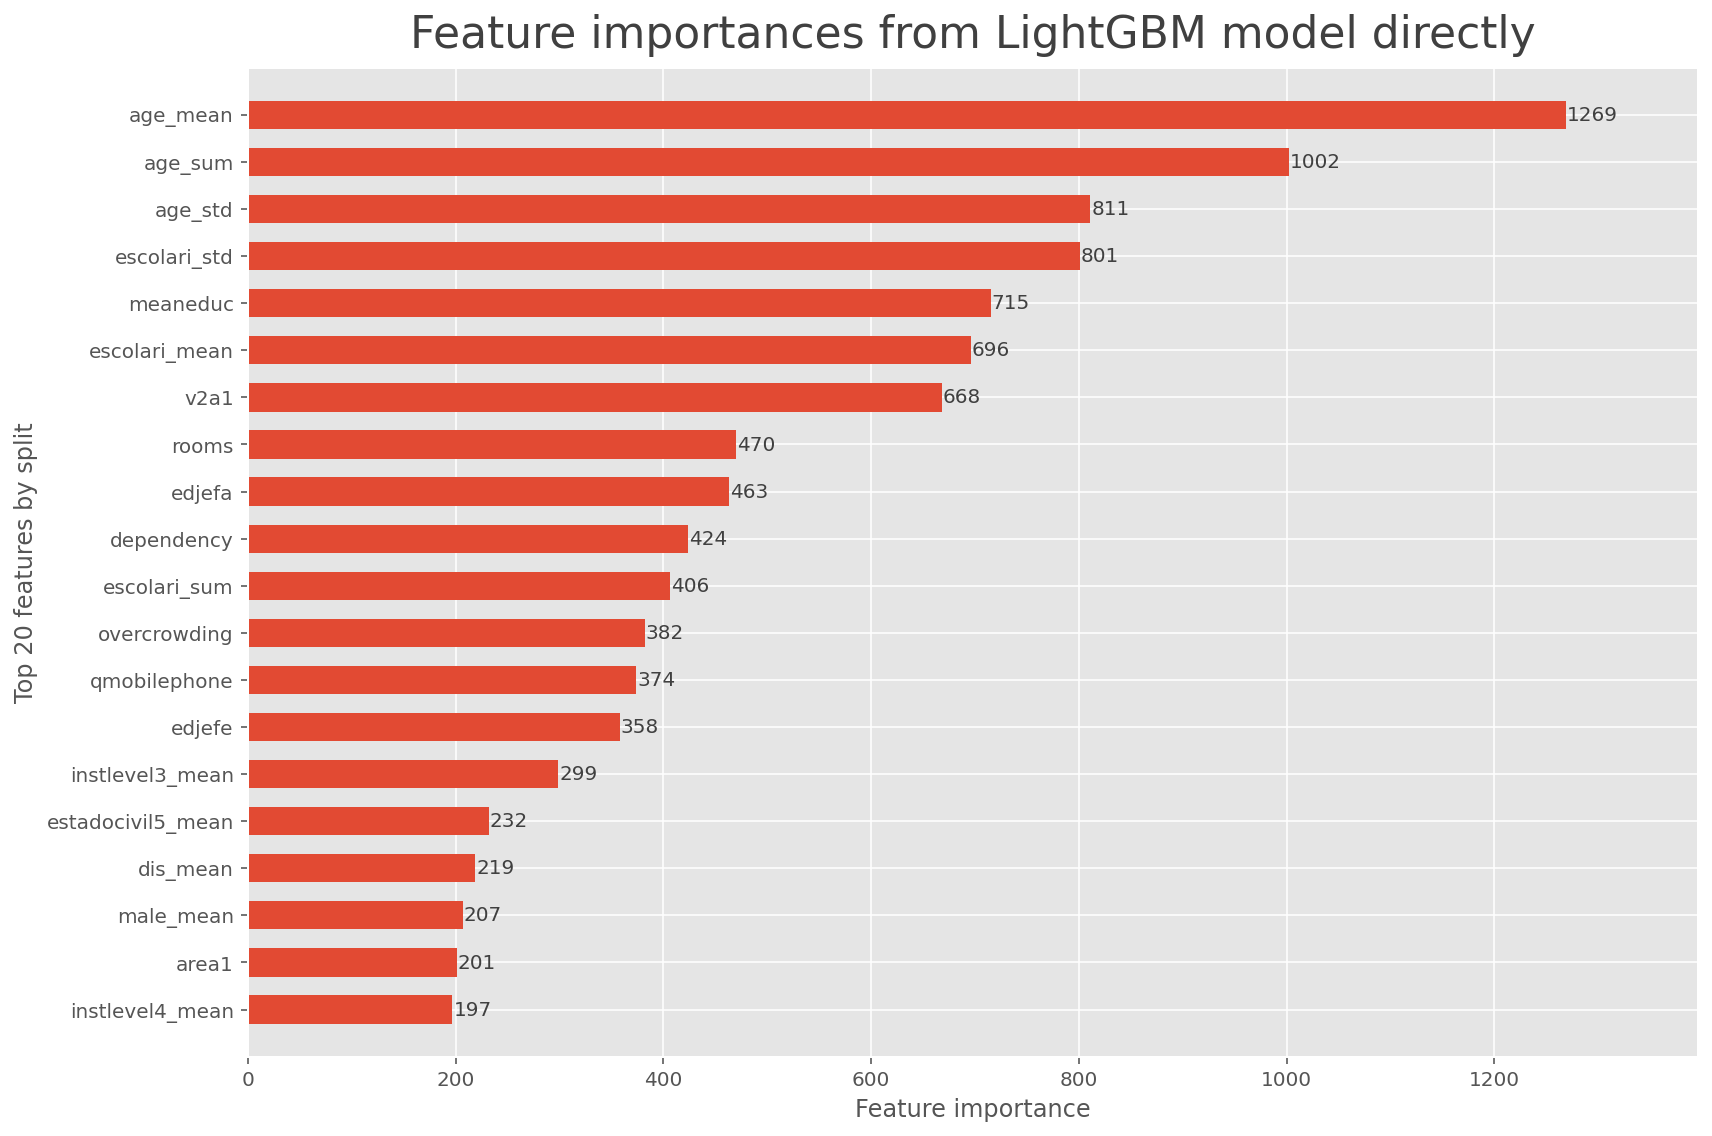

In [57]:
# We can use either split or gain as importance type
# Results are slightly different but relevant features stay the same
lgb.plot_importance(pipe.steps[0][1],figsize=(12,8), 
                    importance_type="split", 
                    max_num_features=20, 
                    height=0.6
                   )
plt.title("Feature importances from LightGBM model directly", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ylabel("Top 20 features by split")
plt.tight_layout()
plt.show()

**Alternatively we calculate the feature importance with scikit's permutation function which is less error-prone.**

Comparing the results we notice:
- Quite a few important features found by permutation are the same as those we directly got from the model.
- `age_mean` is the most important features in both assessments.
- Many of the important features are demographic (age, education, sex).
- Many of the newly created features contribute a lot e.g., `escolari_mean`, `age_mean`. I take this as another indication that aggregating to households is a promising approach.
- It's interesting that the possession of a mobilephone ranks among the strongest indicators.
- It's interesting too that not many of the correlated features (see EDA) rank very high here.

In [58]:
%%time
result = permutation_importance(pipe, 
                                X_agg, y_agg,
                                scoring="f1_macro", 
                                n_repeats=10,
                                random_state=0)

CPU times: user 17min 12s, sys: 47.2 s, total: 17min 59s
Wall time: 2min 36s


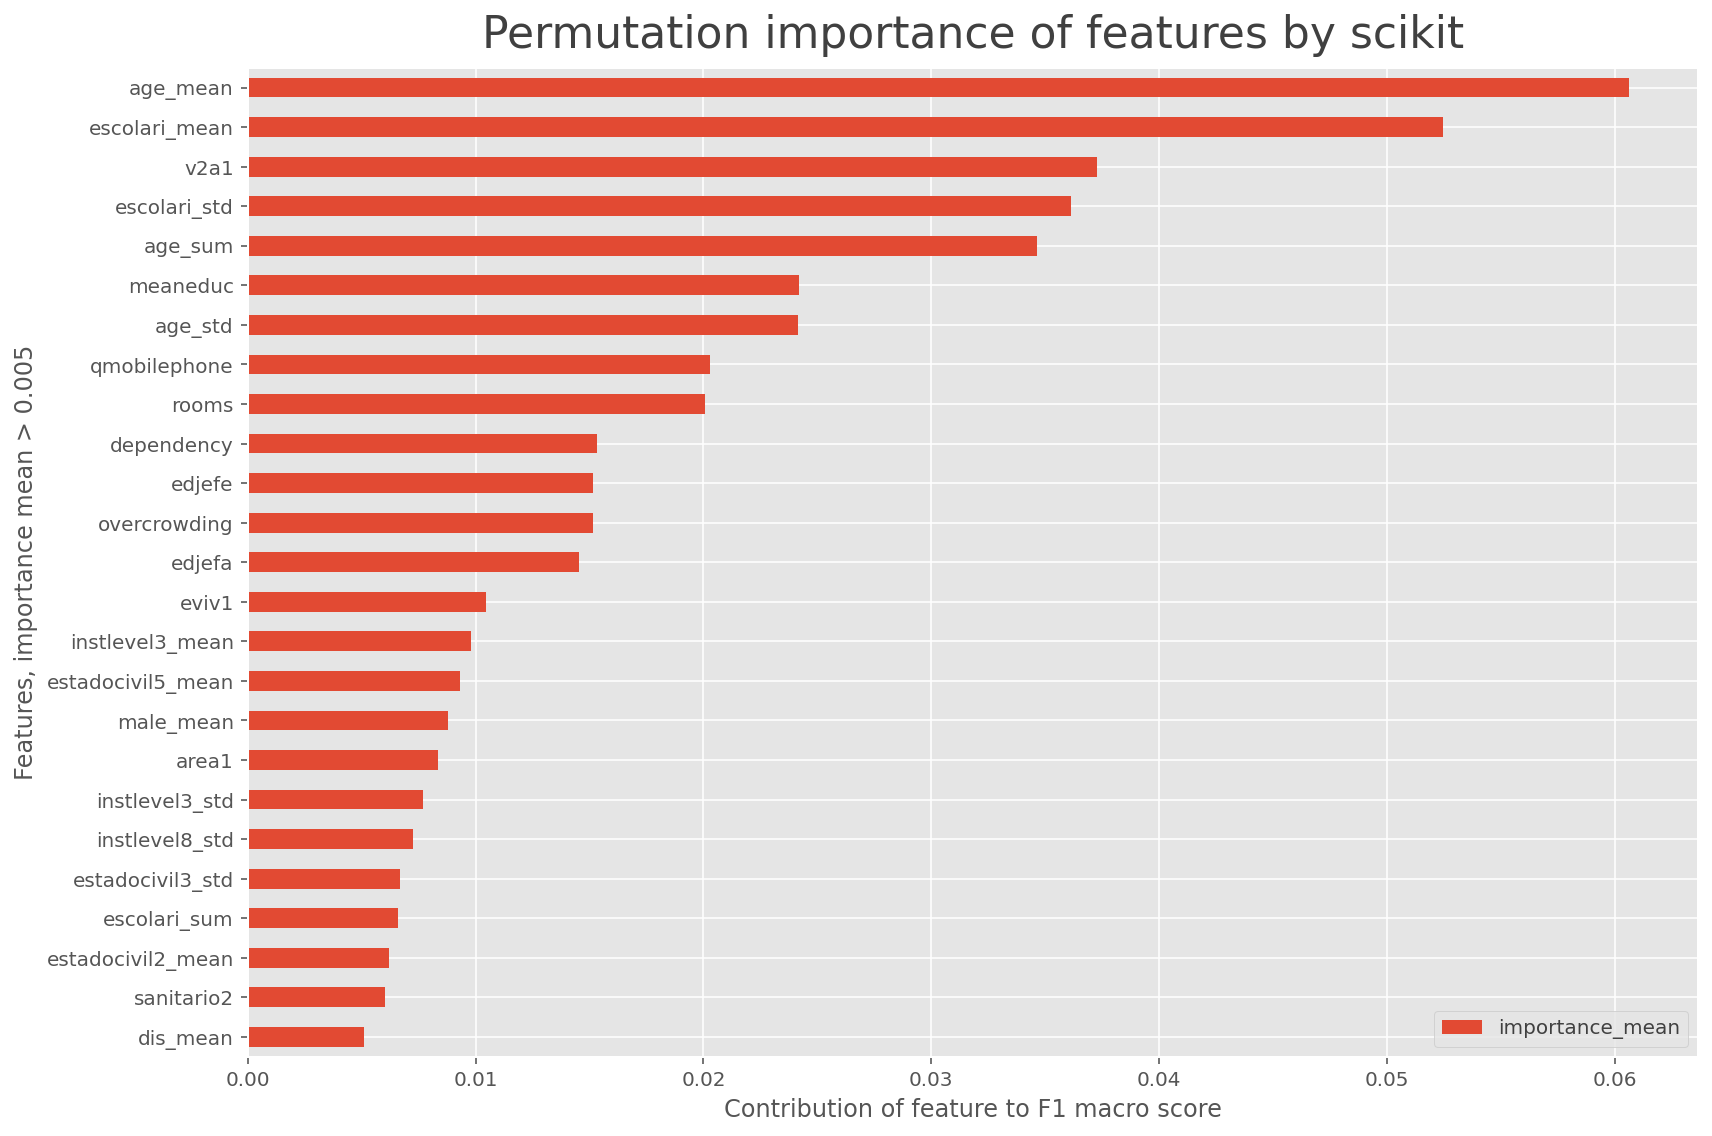

In [59]:
df_results = pd.DataFrame(result["importances_mean"])
df_results.columns = ["importance_mean"]
df_results = df_results[df_results["importance_mean"] > 0.005]
df_results.sort_values(by="importance_mean", ascending=True, inplace=True)
feature_labels = X_agg.columns[df_results.index]

df_results.plot.barh(figsize=(12,8))
plt.yticks(ticks=range(0,len(df_results)), labels=feature_labels)
plt.title("Permutation importance of features by scikit", size=TITLE_SIZE, pad=TITLE_PADDING)
plt.ylabel("Features, importance mean > 0.005")
plt.xlabel("Contribution of feature to F1 macro score")
plt.tight_layout()
plt.show()

**How does a model compare that is only trained on the important features we just found by permutation?**
- The local score is worse with less features. 
- On Kaggle we do not gain either: 0.4182.

In [60]:
clf = lgb.LGBMClassifier(**hyperparams_agg)

scores = cross_val_score(clf, X_agg, y_agg, scoring="f1_macro", n_jobs=-1, cv=10)
mean_score = np.mean(scores)
print(f"F1 macro – all features: {mean_score:.4f}")

scores = cross_val_score(clf, X_agg[feature_labels], y_agg, scoring="f1_macro", n_jobs=-1, cv=10)
mean_score = np.mean(scores)
print(f"F1 macro – only important features: {mean_score:.4f}")

F1 macro – all features: 0.4195
F1 macro – only important features: 0.4033


## Interaction features
We can now use the list of most relevant features to create interaction features. 
- **Locally this yields 0.4219 (previous best score: 0.4273)**
- On Kaggle we get 0.4176 which is not an improvement either.

In [61]:
X_int = X_agg.copy()
for comb in list(combinations(feature_labels, 2)):
    X_int[str(comb[0]) + '_x_' + str(comb[1])] = X_int[comb[0]] * X_int[comb[1]]

/var/folders/_r/4lzb3mms1zlfjdqnv697_rw00000gn/T/ipykernel_11075/4171204730.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X_int[str(comb[0]) + '_x_' + str(comb[1])] = X_int[comb[0]] * X_int[comb[1]]


In [62]:
clf = lgb.LGBMClassifier(**hyperparams_agg)
scores = cross_val_score(clf, X_int, y_agg, scoring="f1_macro", n_jobs=-1, cv=10)
mean_score = np.mean(scores)
print(f"F1 macro – with interaction features: {mean_score:.4f}")

F1 macro – with interaction features: 0.4219


# 4) Using imbalanced learn
---

Let's **try several oversampling techniques to counter the imbalance of the target**.
- Again – we can't use the `cross_val_score` function here because we have to split test/train before upsampling to avoid same households in both splits.
- Our unsampled baseline is **0.4108**.
- Only SMOTE yields an improved score of 0.4173. All the other upsampling methods rank worse.
- The SMOTE score isn't above our best previous value though.

In [63]:
pipe = make_pipeline(preprocess, lgb.LGBMClassifier(**hyperparams))
scores = []
for random_state in range(0, 5):
    X_train, y_train, X_test, y_test, _ = weighted_split_train_test(train, random_state=random_state)
    pipe.fit(X_train.drop("Id", axis=1), y_train)
    preds = pipe.predict(X_test.drop("Id", axis=1))
    score = f1_score(y_test, preds, average='macro')
    scores.append(score)
print(f"F1 macro – baseline\t: {np.mean(scores):.4f}")

F1 macro – baseline	: 0.4108


In [64]:
samplers = [RandomOverSampler(random_state=0),
            ADASYN(random_state=0), 
            SMOTE(random_state=0),
            BorderlineSMOTE(random_state=0, kind="borderline-1"),
            BorderlineSMOTE(random_state=0, kind="borderline-2"),
            SVMSMOTE(random_state=0)]

sampler_names = ["Random", "Adasyn", "Smote", "BrdSmote1", "BrdSmote2", "SVMSmote"]

for name, sampler in zip(sampler_names, samplers):
    clf = lgb.LGBMClassifier(**hyperparams)
    scores = []
    # train and score on n different splits to make evaluation more robust
    for random_state in range(0, 1):
        X_train, y_train, X_test, y_test, _ = weighted_split_train_test(train, random_state=random_state)
        pipe = make_imb_pipeline(SimpleImputer(), sampler, clf)
        pipe.fit(X_train.drop("Id", axis=1), y_train)
        preds = clf.predict(X_test.drop("Id", axis=1))
        score = f1_score(y_test, preds, average='macro')
        scores.append(score)
    print(f"F1 macro – {name}\t: {np.mean(scores):.4f}")

F1 macro – Random	: 0.3836
F1 macro – Adasyn	: 0.3889
F1 macro – Smote	: 0.4158
F1 macro – BrdSmote1	: 0.3864
F1 macro – BrdSmote2	: 0.3549
F1 macro – SVMSmote	: 0.3945


# 5) Conclusions

- **Finding a suitable algorithm**, **tuning the hyperparams** and **aggregating the data to household level yielded the most substantial gains** (apart from cleaning and generally preparing the data).
- **LightGBM yielded very good results and fast training throughout all experiments.**
- LogisticRegression proved to be a fast and sufficiently good baseline classifier. 
- **Feature engineering by creating interaction features brought gains locally.**
- Category encoding and using featuretools didn't prove to be useful here.
- Upsampling the data didn't bring any gains (apart from SMOTE)
- AutoML with scikit-optimize did not speed up the tuning of the classifier nor brought better hyperparameters. 
- **Best local F1 macro score is 0.422** and **0.434 on Kaggle (rank #111)**.